# Modifying SWESARR Tutorial for evaluation of radar 

In [1]:
# Import several libraries. 
# comments to the right could be useful for local installation on Windows.

from shapely import speedups      # https://www.lfd.uci.edu/~gohlke/pythonlibs/
#speedups.disable()                # <-- handle a potential error in cartopy

import requests                   # !conda install -c anaconda requests 

# raster manipulation libraries
import rasterio                   # https://www.lfd.uci.edu/~gohlke/pythonlibs/
from osgeo import gdal            # https://www.lfd.uci.edu/~gohlke/pythonlibs/
import cartopy.crs as ccrs        # https://www.lfd.uci.edu/~gohlke/pythonlibs/
import rioxarray as rxr           # !conda install -c conda-forge rioxarray
import xarray as xr               # !conda install -c conda-forge xarray dask netCDF4 bottleneck

# SnowEx Pit Data!
from snowexsql.api import LayerMeasurements # pip install snowexsql

# plotting tools
from matplotlib import pyplot     # !conda install matplotlib
import datashader as ds           # https://www.lfd.uci.edu/~gohlke/pythonlibs/
import hvplot.xarray              # !conda install hvplot
import hvplot.pandas
import holoviews as hv

# append the subfolders of the current working directory to pythons path
import os, sys, glob

swesarr_subdirs = ["data", "util"]
tmp = [sys.path.append(os.getcwd() + "/" + sd) for sd in swesarr_subdirs]
del tmp # suppress Jupyter notebook output, delete variable

# lambda functions!
to_nl = lambda a: 10**(a/10)
to_db = lambda a: 10*np.log10(a)

# settings to make matplotlib look nicer!
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 4.5) # (w, h)

#############################################
# Suppress Warnings for Cleaner Output      #
# (Address Warnings in future update)       #
import warnings                             #
warnings.filterwarnings('ignore')           #
#############################################
sys.path.append('./util/')
from helper import get_out_dir, gdal_corners, join_files, join_sar_radiom, filt_pit_to_sar, filt_radiom_points, sar_swe_plot, radiom_swe_plot, rough_radiom_area

In [2]:
import numpy as np

In [3]:
# Grab snow depth 
def fn_list(thisDir, fn_pattern, verbose=False):
    """Match and sort filenames based on a regex pattern in specified directory

    Parameters
    -------------
    thisDir: str
        directory path to search
    fn_pattern: str
        regex pattern to match files
    verbose: boolean
        print filenames
    
    Returns
    -------------
    fns: list
        list of filenames matched and sorted
    """
    import glob
    fns=[]
    for f in glob.glob(thisDir + "/" + fn_pattern):
        fns.append(f)
    fns.sort()
    if verbose: print(fns)
    return fns


In [4]:
work_dir = '/home/jovyan/shared-public/swesarr_project/'
nc_list = fn_list(work_dir, 'lidar/*nc')

In [5]:
# Look at the images that Dylan uploaded

In [6]:
radar_fns = fn_list(work_dir, '*radar/v3_tifs/*tif')
radar_fns

['/home/jovyan/shared-public/swesarr_project/swesarr-radar/v3_tifs/GRMST1_27201_20008_021_200212_09225VV_XX_01.tif',
 '/home/jovyan/shared-public/swesarr_project/swesarr-radar/v3_tifs/GRMST1_27401_19003_007_191104_09225VV_XX_01.tif',
 '/home/jovyan/shared-public/swesarr_project/swesarr-radar/v3_tifs/GRMST1_27401_19004_005_191105_09225VV_XX_01.tif',
 '/home/jovyan/shared-public/swesarr_project/swesarr-radar/v3_tifs/GRMST1_27401_19005_008_191106_09225VV_XX_01.tif',
 '/home/jovyan/shared-public/swesarr_project/swesarr-radar/v3_tifs/GRMST1_27401_20007_005_200211_09225VV_XX_01.tif',
 '/home/jovyan/shared-public/swesarr_project/swesarr-radar/v3_tifs/GRMST1_27402_19003_013_191104_09225VV_XX_01.tif',
 '/home/jovyan/shared-public/swesarr_project/swesarr-radar/v3_tifs/GRMST1_27402_19004_011_191105_09225VV_XX_01.tif',
 '/home/jovyan/shared-public/swesarr_project/swesarr-radar/v3_tifs/GRMST1_27402_19005_014_191106_09225VV_XX_01.tif',
 '/home/jovyan/shared-public/swesarr_project/swesarr-radar/v3_ti

CPU times: user 1.97 s, sys: 767 ms, total: 2.74 s
Wall time: 3 s


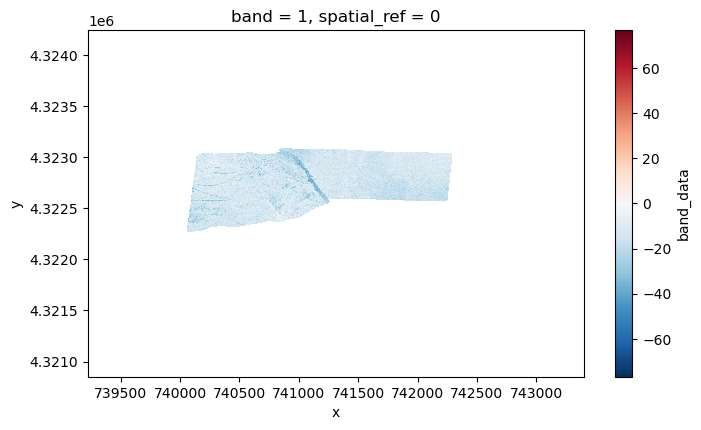

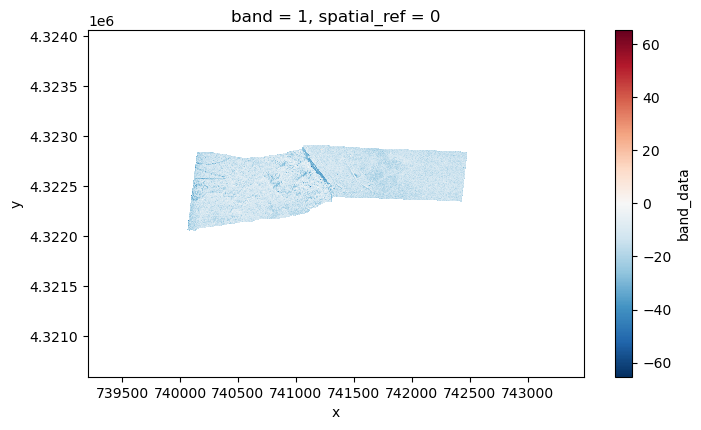

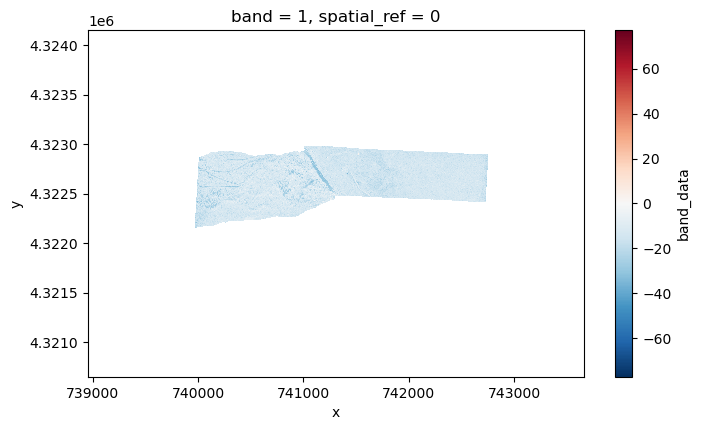

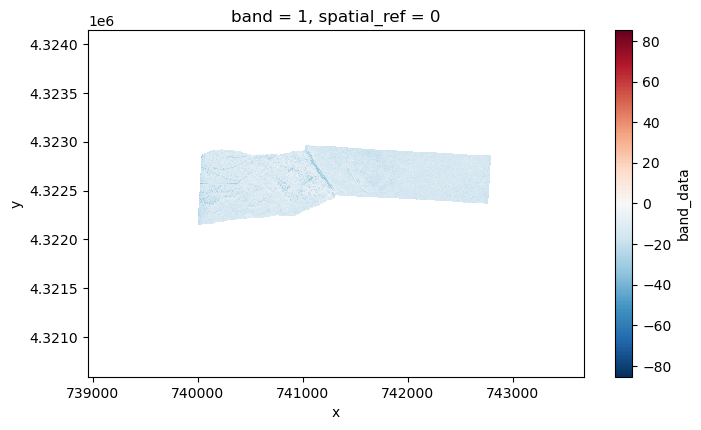

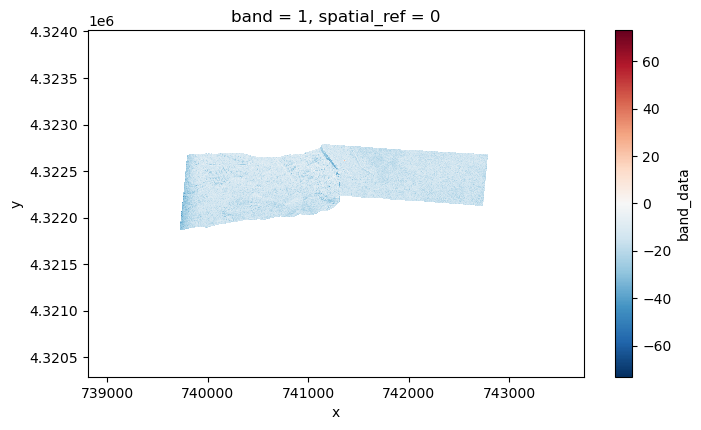

In [8]:
%%time
radar_list = [np.squeeze(xr.open_dataset(rfn)) for rfn in radar_fns]
for jdx, backscatter in enumerate(radar_list):
    # break
    fig, ax = plt.subplots()
    backscatter['band_data'].plot.imshow(ax=ax)
    if jdx > 3:
        break
# del radar_list

In [9]:
xr.open_dataset(radar_fns[0])

<xarray.Dataset> Size: 57MB
Dimensions:      (band: 1, x: 4179, y: 3392)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 33kB 7.392e+05 7.392e+05 ... 7.434e+05 7.434e+05
  * y            (y) float64 27kB 4.324e+06 4.324e+06 ... 4.321e+06 4.321e+06
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band, y, x) float32 57MB ...

In [10]:
import xarray as xr

In [11]:
sd_list = [xr.open_dataset(nc_fn) for nc_fn in nc_list]

In [12]:
sd_list[0]

<xarray.Dataset> Size: 4kB
Dimensions:  (y: 21, x: 42)
Coordinates:
  * y        (y) float64 168B 4.323e+06 4.323e+06 ... 4.322e+06 4.322e+06
  * x        (x) float64 336B 7.408e+05 7.409e+05 ... 7.428e+05 7.429e+05
Data variables:
    swe      (y, x) float32 4kB ...

In [13]:
import geopandas as gpd

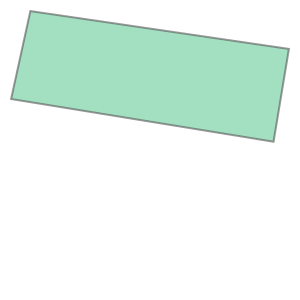

In [18]:
roi_fn = "/home/jovyan/shared-public/swesarr_project/base-layers/swesarr-roi/swesarr-roi.shp"
poly = gpd.read_file(roi_fn)
poly['name'] = ['swesarr_bbox']
poly_32613 = poly.to_crs(epsg=32613)
poly_32613.geometry[0]

In [19]:
for f in poly.geometry:
    print(f)

POLYGON ((-108.21570641810067 39.023945943313166, -108.19531884215058 39.0221881018874, -108.19626765553384 39.01647660780745, -108.2169736520879 39.01852388325856, -108.21570641810067 39.023945943313166))


## Pull snow depth from snowex database

In [20]:
%%time
# import in the raster measurements class
from snowexsql.api import RasterMeasurements
from datetime import datetime 
from rasterio.plot import show

# Pick the dates (can also find them from the filter unique example)

dt_list = [datetime(2020, 2, 2), datetime(2020, 2, 13)]

# Query db filtering to swe on a certain date surveyed by ASO
ds_list = [RasterMeasurements.from_filter(observers='ASO Inc.', date=dt, type='depth') for dt in dt_list]

# Note the resolution!
[ds[0].res for ds in ds_list]

CPU times: user 1.37 s, sys: 871 ms, total: 2.24 s
Wall time: 39.8 s


[(3.000000000007304, 3.000000000007304),
 (3.000000000007304, 3.000000000007304)]

In [21]:
# pull transforms for plotting and localized writing
transforms = [ds[0].transform for ds in ds_list]
depth_arrays = [ds[0].read() for ds in ds_list]
profiles = [ds[0].profile for ds in ds_list]

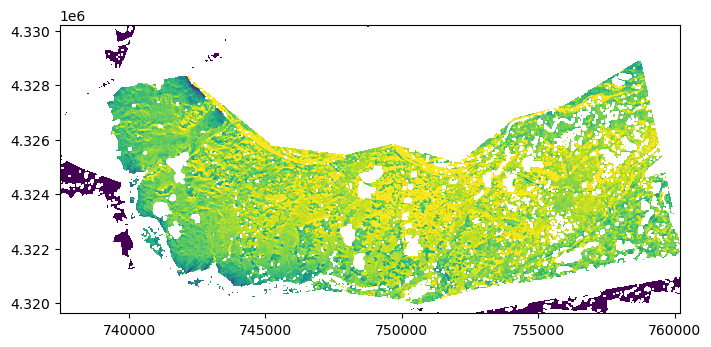

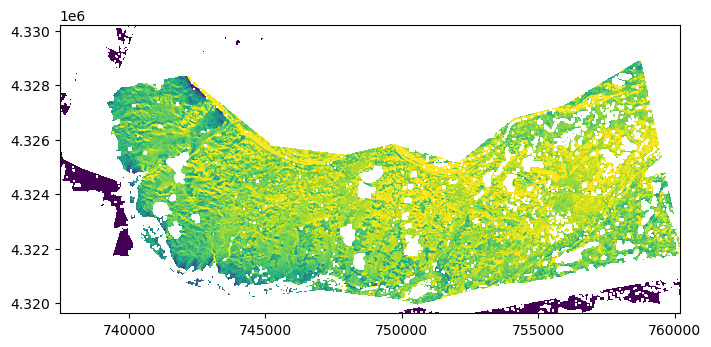

In [22]:
for depth, transform in zip(depth_arrays, transforms):
    depth = np.squeeze(depth)
    show(depth, transform=transform, vmin=0, vmax=np.nanpercentile(depth, 84))

In [23]:
%%time
depth_diff = depth_arrays[1] - depth_arrays[0]

CPU times: user 41.9 ms, sys: 404 µs, total: 42.3 ms
Wall time: 41.6 ms


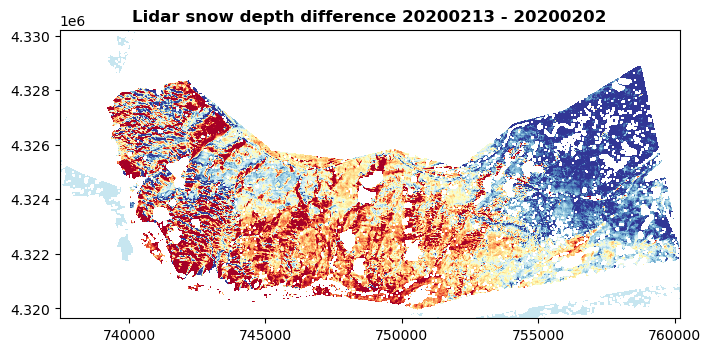

In [24]:
p = 16
vmin = np.nanpercentile(depth_diff, p)
vmax = np.nanpercentile(depth_diff, 100-p)
cmap = 'RdYlBu'
title = 'Lidar snow depth difference 20200213 - 20200202'
show(depth_diff, transform=transform, vmin=vmin, vmax=vmax, cmap='RdYlBu', title=title);

## Write it out for posterity

In [25]:
outname = 'test.tif'
if not os.path.exists(outname):
    with rasterio.Env():
        # Write an array as a raster band to a new 8-bit file. For
        # the new file's profile, we start with the profile of the source
        profile = profiles[0]
    
        # And then change the band count to 1, set the
        # dtype to uint8, and specify LZW compression.
        profile.update(
            dtype=rasterio.float32,
            count=1,
            compress='lzw')
    
        with rasterio.open(outname, 'w', **profile) as dst:
            dst.write(depth_diff)

# read it back in to check
test = np.squeeze(xr.open_dataset(outname))
test

<xarray.Dataset> Size: 107MB
Dimensions:      (x: 7576, y: 3528)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 61kB 7.375e+05 7.375e+05 ... 7.602e+05 7.602e+05
  * y            (y) float64 28kB 4.33e+06 4.33e+06 ... 4.32e+06 4.32e+06
    spatial_ref  int64 8B ...
Data variables:
    band_data    (y, x) float32 107MB ...

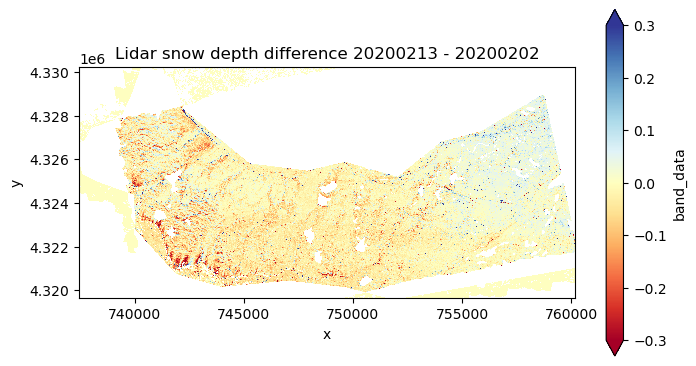

In [30]:
fig, ax = plt.subplots()
test['band_data'].plot.imshow(vmin=-0.3, vmax=0.3, ax=ax, cmap=cmap)
ax.set_aspect('equal')
ax.set_title(title);

### Crop to ROI!

EPSG:26912


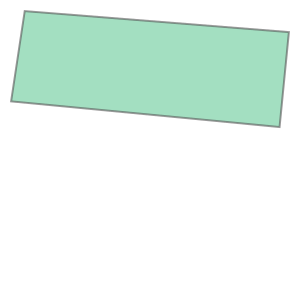

In [27]:
crs = profiles[0]['crs']
print(crs)
poly_reproj = poly.to_crs(crs=crs)
poly_reproj.geometry[0]

In [28]:
clipped = test.rio.clip(poly_reproj.geometry)
clipped

<xarray.Dataset> Size: 650kB
Dimensions:      (x: 621, y: 259)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 5kB 7.409e+05 7.409e+05 ... 7.428e+05 7.428e+05
  * y            (y) float64 2kB 4.323e+06 4.323e+06 ... 4.322e+06 4.322e+06
    spatial_ref  int64 8B 0
Data variables:
    band_data    (y, x) float32 643kB nan nan nan nan nan ... nan nan nan nan

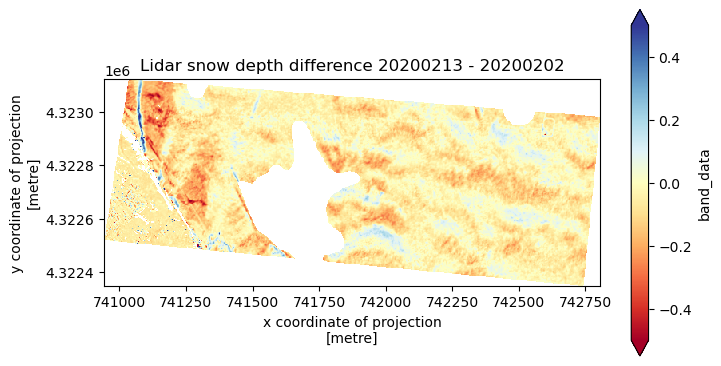

In [29]:
# vmin = np.nanpercentile(clipped['band_data'].values, p)
# vmax = np.nanpercentile(clipped['band_data'].values, 100-p)
fig, ax = plt.subplots()
clipped['band_data'].plot.imshow(vmin=-0.5, vmax=0.5, ax=ax, cmap=cmap)
ax.set_aspect('equal')
ax.set_title(title);